In [1]:
from gensim.models import Word2Vec
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE



In [2]:
decades = ['1850s', '1860s', '1870s', '1880s', '1930s']


In [3]:
base_path = "/xdisk/cjgomez/joshdunlapc/word2vec_models"

In [4]:
models = {}
for decade in decades:
    model_path = os.path.join(base_path, decade, f"word2vec_{decade}.model")
    if os.path.exists(model_path):
        print(f"Loading model for {decade}...")
        models[decade] = Word2Vec.load(model_path)
    else:
        print(f"Model for {decade} not found at {model_path}")

Loading model for 1850s...
Loading model for 1860s...
Loading model for 1870s...
Loading model for 1880s...
Loading model for 1930s...


In [5]:
tests = {
    "gender": {'positive': ['father', 'woman'], 'negative': ['man'], 'topn': 3},
    "geography": {'positive': ['france', 'berlin'], 'negative': ['paris'], 'topn': 3},
}

# Run tests and print labeled output
for decade, model in models.items():
    print(f"\n=== Results for {decade} ===")
    for test_name, params in tests.items():
        print(f"\n{test_name.capitalize()} analogy:")
        try:
            result = model.wv.most_similar(**params)
            for word, similarity in result:
                print(f"  {word}: {similarity:.3f}")
        except KeyError as e:
            print(f"  Skipped: word not in vocabulary ({e})")


=== Results for 1850s ===

Gender analogy:
  mother: 0.643
  sister: 0.590
  husband: 0.572

Geography analogy:
  prussia: 0.614
  germany: 0.556
  russia: 0.523

=== Results for 1860s ===

Gender analogy:
  grandmother: 0.538
  mother: 0.536
  fattier: 0.491

Geography analogy:
  prussia: 0.711
  austria: 0.678
  russia: 0.648

=== Results for 1870s ===

Gender analogy:
  mother: 0.734
  sister: 0.554
  fatlier: 0.541

Geography analogy:
  germany: 0.726
  austria: 0.664
  prussia: 0.664

=== Results for 1880s ===

Gender analogy:
  mother: 0.694
  sister: 0.582
  grandmother: 0.572

Geography analogy:
  germany: 0.757
  austria: 0.648
  gormany: 0.643

=== Results for 1930s ===

Gender analogy:
  mother: 0.638
  husband: 0.610
  grandmother: 0.566

Geography analogy:
  germany: 0.795
  italy: 0.630
  belgium: 0.604


In [6]:
def get_neighbors(word, model, decade, topn=10):
    """
    Prints and returns top-n similar words for a given word, model, and decade.
    """
    try:
        neighbors = model.wv.most_similar(word, topn=topn)
    except KeyError:
        print(f"Word '{word}' missing from vocabulary for {decade}.")
        return None

    print(f"\n{decade} — Most similar words to '{word}':")
    for w, sim in neighbors:
        print(f"  {w}: {sim:.4f}")
    return neighbors


In [7]:
def plot_word_neighbors(word, model, decade, topn=15):
    """
    TSNE plot of a word and its nearest neighbors for a given decade.
    """
    try:
        neighbors = model.wv.most_similar(word, topn=topn)
    except KeyError:
        print(f"Word '{word}' missing from vocabulary for {decade}.")
        return

    words_to_plot = [word] + [n for n, _ in neighbors]
    vectors = np.array([model.wv[w] for w in words_to_plot])

    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    coords = tsne.fit_transform(vectors)

    plt.figure(figsize=(8, 6))
    for (x, y), w in zip(coords, words_to_plot):
        if w == word:
            plt.scatter(x, y, s=150, color="red", marker="*")
            plt.text(x+0.01, y+0.01, w, fontsize=14, fontweight="bold", color="red")
        else:
            plt.scatter(x, y, s=80, color="blue")
            plt.text(x+0.01, y+0.01, w, fontsize=12)

    plt.title(f"{decade}: neighbors of '{word}'", fontsize=16)
    plt.show()


In [8]:
for decade, model in models.items():
    get_neighbors("", model, decade, topn=10)

Word '' missing from vocabulary for 1850s.
Word '' missing from vocabulary for 1860s.
Word '' missing from vocabulary for 1870s.
Word '' missing from vocabulary for 1880s.
Word '' missing from vocabulary for 1930s.


In [42]:
import numpy as np
from sklearn.preprocessing import normalize

def compute_temporality_axis(model, pairs):
    """
    Computes the temporality axis for a single decade-specific model.
    Skips any pair where one or both words are missing.
    Returns None if no usable pairs.
    """
    diffs = []
    for a, b in pairs:
        if a in model.wv and b in model.wv:
            diffs.append(model.wv[a] - model.wv[b])

    if not diffs:
        return None  # No axis possible for this model

    axis = np.mean(diffs, axis=0)
    axis = normalize(axis.reshape(1, -1))[0]
    return axis


def temporality_score(model, axis, word):
    """
    Computes a word’s score along the temporal axis.
    Returns None if word missing OR axis missing.
    """
    if axis is None:
        return None
    if word not in model.wv:
        return None

    vec = normalize(model.wv[word].reshape(1, -1))[0]
    return float(np.dot(vec, axis))


# ----------------------------
# Setup
# ----------------------------

pairs = [
    ("future", "past"),
    ("new", "old"),
    ("tomorrow", "yesterday"),
    ("modern", "antiquity"),
]

probe_words = [
    "technology", "electricity",
    "memory", "phonograph",
    "ruins", "monarchy", 
]

results = {}  # decade → {word: score}


# ----------------------------
# Main loop
# ----------------------------

for decade, model in models.items():
    print(f"\nProcessing {decade}...")

    axis = compute_temporality_axis(model, pairs)

    decade_scores = {
        w: temporality_score(model, axis, w)
        for w in probe_words
    }

    results[decade] = decade_scores




Processing 1850s...

Processing 1860s...

Processing 1870s...

Processing 1880s...

Processing 1930s...


In [43]:
def sort_results_by_score(results):
    """
    Takes the results dict:
        decade → {word: score or None}
    Returns a new dict:
        decade → [(word, score), ...] sorted high → low
    """
    sorted_results = {}

    for decade, scores in results.items():
        # Remove None values
        valid = [(w, s) for w, s in scores.items() if s is not None]

        # Sort by score descending (future-like -> past-like)
        valid_sorted = sorted(valid, key=lambda x: x[1], reverse=True)

        sorted_results[decade] = valid_sorted

    return sorted_results

In [44]:
sort_results_by_score(results)

{'1850s': [('technology', 0.006344583351165056),
  ('electricity', -0.01738555170595646),
  ('monarchy', -0.041190363466739655),
  ('memory', -0.08828125149011612),
  ('ruins', -0.2215605527162552)],
 '1860s': [('electricity', 0.007714158855378628),
  ('monarchy', 0.005550499074161053),
  ('memory', -0.10008976608514786),
  ('ruins', -0.1522868573665619)],
 '1870s': [('phonograph', 0.11711637675762177),
  ('technology', 0.029421618208289146),
  ('electricity', -0.011230532079935074),
  ('monarchy', -0.028055215254426003),
  ('memory', -0.1691347062587738),
  ('ruins', -0.17885291576385498)],
 '1880s': [('electricity', 0.14353595674037933),
  ('phonograph', 0.08204799890518188),
  ('technology', 0.029027827084064484),
  ('monarchy', -0.07368753850460052),
  ('ruins', -0.14154541492462158),
  ('memory', -0.1520373821258545)],
 '1930s': [('electricity', 0.1252446323633194),
  ('technology', 0.026575356721878052),
  ('phonograph', -0.047865431755781174),
  ('memory', -0.11402479559183121),

In [47]:
from sklearn.preprocessing import normalize

def plot_tsne_with_temporality(model, axis, words, decade_label=None, perplexity=15):
    if axis is None:
        print(f"[{decade_label}] No temporality axis; skipping.")
        return

    # Filter in-vocab words
    vocab_words = [w for w in words if w in model.wv]
    if len(vocab_words) < 3:
        print(f"[{decade_label}] Not enough words for t-SNE (need ≥3). Skipping.")
        return

    # Build matrix
    vecs = np.vstack([model.wv[w] for w in vocab_words])

    # Normalize axis
    axis_norm = axis / np.linalg.norm(axis)

    # Temporality scores
    norm_vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)
    scores = norm_vecs @ axis_norm

    # Auto-adjust perplexity
    safe_perp = min(perplexity, len(vocab_words) - 1)
    if safe_perp < 2:
        safe_perp = 2

    # Run t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=safe_perp,
        init="random",
        random_state=42,
    )
    tsne_points = tsne.fit_transform(vecs)

    # Now embed the axis direction using the *same* TSNE object
    axis_vecs = np.vstack([axis_norm, -axis_norm])
    axis_tsne = tsne.fit_transform(
        np.vstack([vecs, axis_vecs])
    )[-2:]  # last two rows = +axis, -axis

    # Plot
    plt.figure(figsize=(10, 7))

    scatter = plt.scatter(
        tsne_points[:, 0],
        tsne_points[:, 1],
        c=scores,
        cmap="coolwarm",
        s=100,
        edgecolor="black",
    )

    # Annotate points
    for (x, y), w in zip(tsne_points, vocab_words):
        plt.text(x + 0.3, y + 0.3, w, fontsize=10)

    # Draw temporality axis arrow
    start = axis_tsne[1]  # past-like
    end = axis_tsne[0]    # future-like
    plt.arrow(
        start[0], start[1],
        end[0] - start[0], end[1] - start[1],
        color="black", linewidth=2,
        head_width=0.8, length_includes_head=True
    )

    plt.text(end[0], end[1], "→ Future", fontsize=10, fontweight='bold')
    plt.text(start[0], start[1], "Past ←", fontsize=10, fontweight='bold')

    plt.title(f"t-SNE + Temporality Axis ({decade_label})")
    plt.colorbar(scatter, label="Temporality Score")
    plt.tight_layout()
    plt.show()


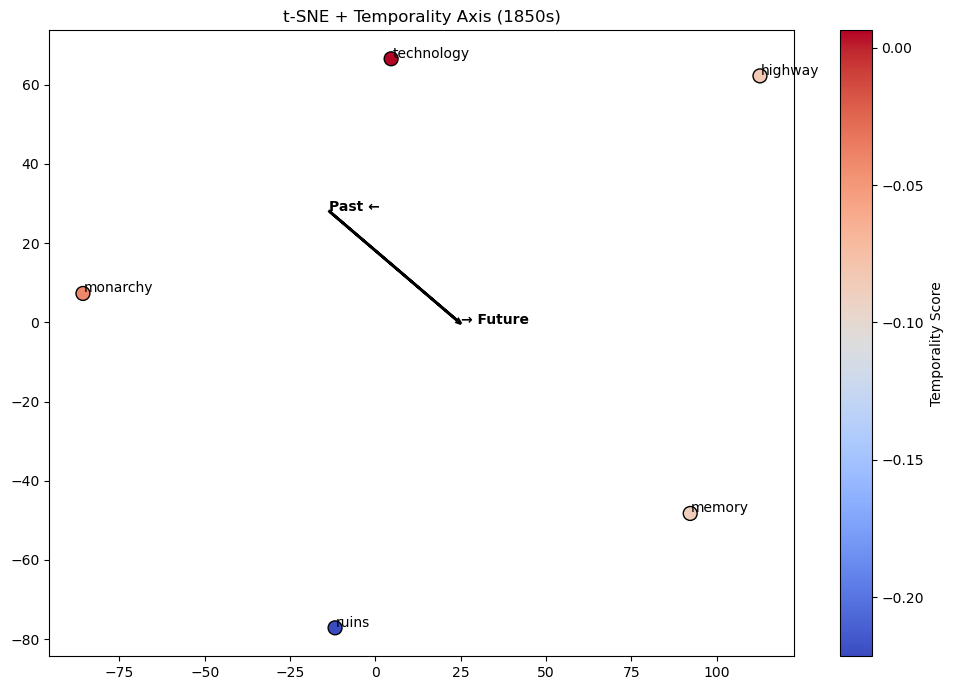

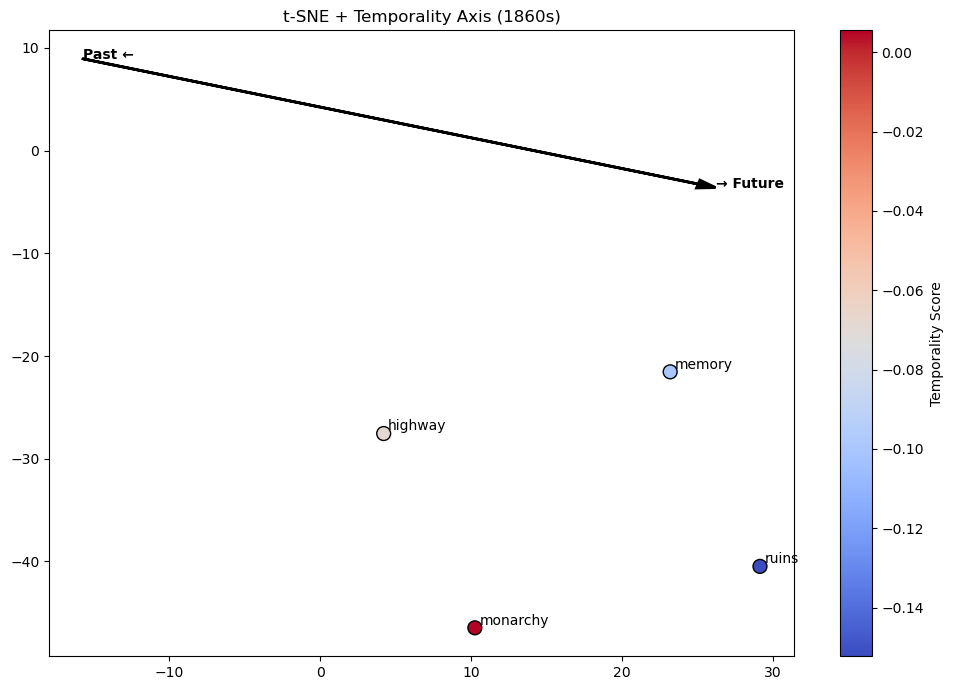

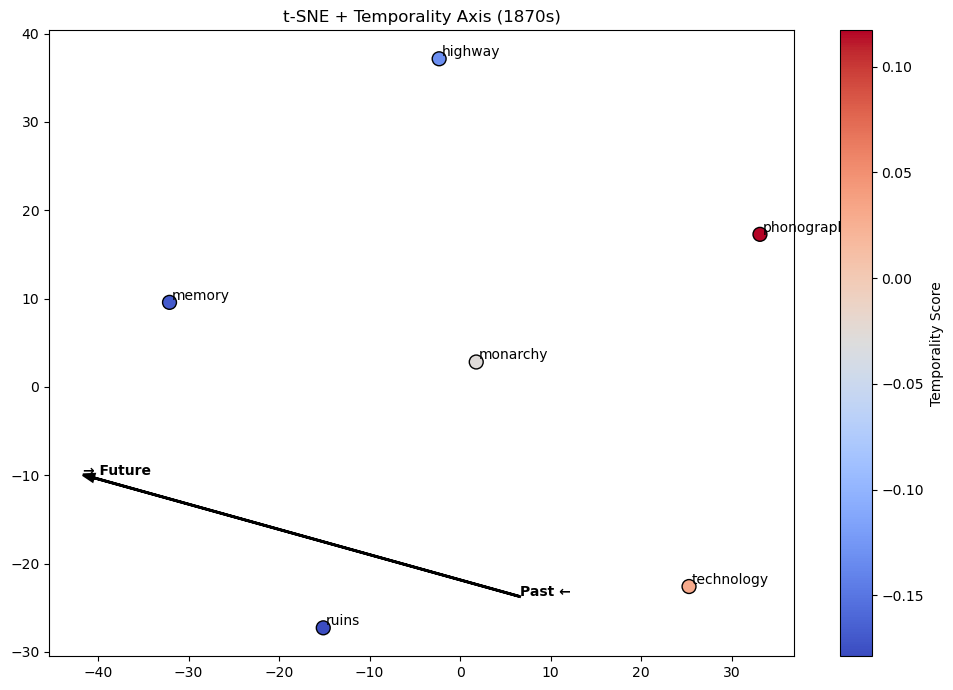

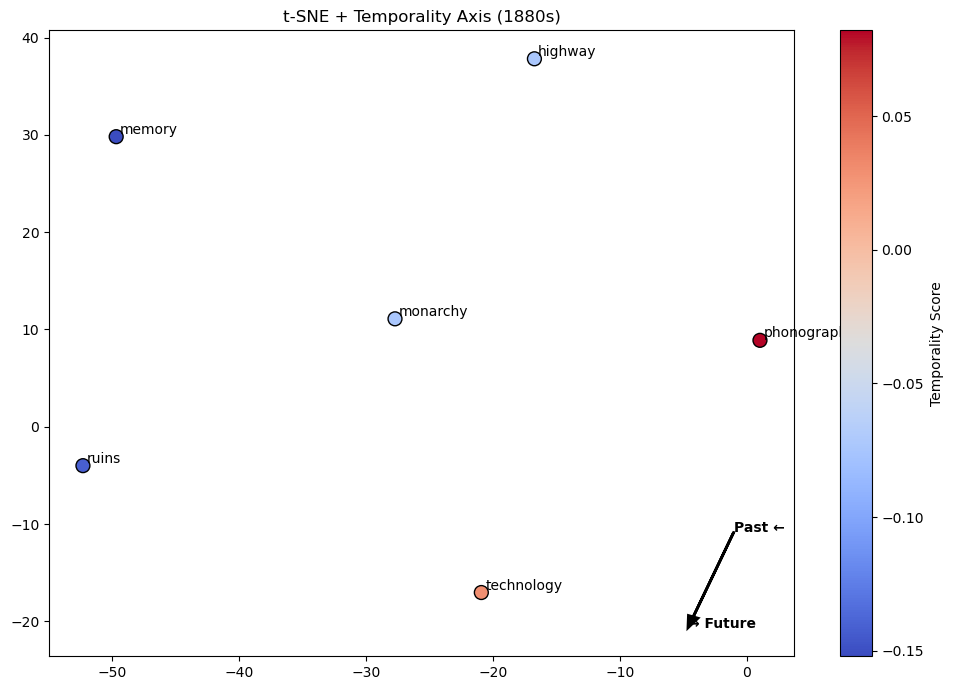

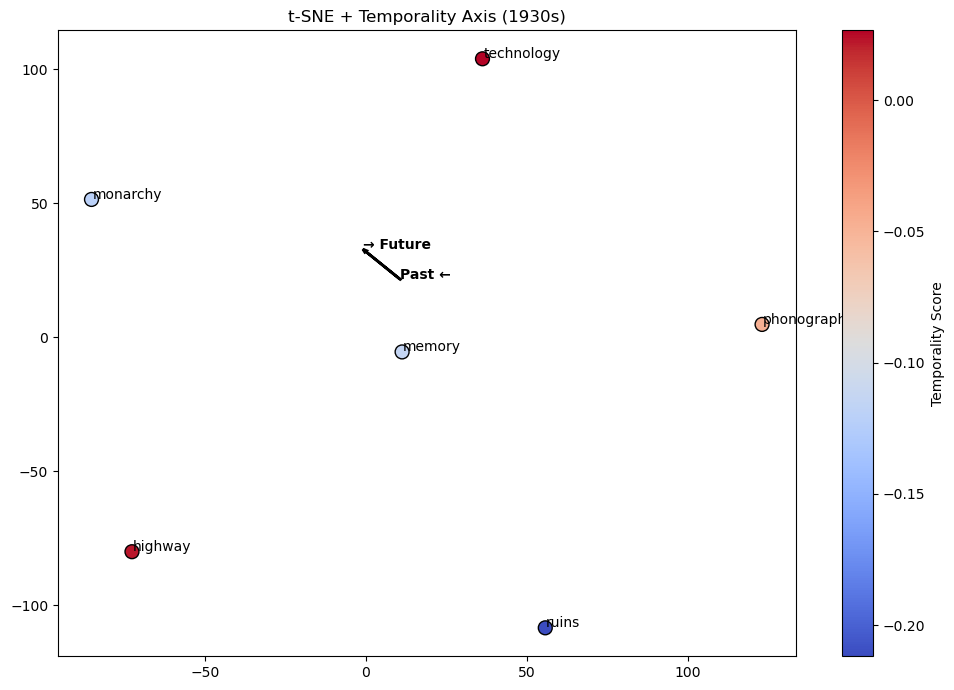

In [88]:
words_to_plot = [
    "technology", "monarchy",
    "memory", "phonograph",
    "ruins", "highway"
]

for decade, model in models.items():
    axis = compute_temporality_axis(model, pairs)
    plot_tsne_with_temporality(model, axis, words_to_plot, decade_label=decade)

In [89]:
def plot_temporality_words(model, axis, words, decade_label=None, min_sep=0.03):
    """
    Plots words along the temporality axis with vertical jitter to avoid overlapping labels.
    min_sep = minimum horizontal distance between labels before jitter activates.
    """
    if axis is None:
        print("No axis available for this model; skipping plot.")
        return
    
    axis_norm = axis / np.linalg.norm(axis)

    # Collect scores
    scores = {}
    for w in words:
        if w in model.wv:
            vec = model.wv[w]
            vec_norm = vec / np.linalg.norm(vec)
            scores[w] = float(np.dot(vec_norm, axis_norm))

    if not scores:
        print("No valid words found in vocabulary.")
        return

    # Sort words by axis score
    sorted_words = sorted(scores.keys(), key=lambda w: scores[w])
    sorted_scores = np.array([scores[w] for w in sorted_words])

    # ---- NEW: Compute jitter y-values ----
    y_positions = np.zeros(len(sorted_scores))
    for i in range(1, len(sorted_scores)):
        if abs(sorted_scores[i] - sorted_scores[i-1]) < min_sep:
            # offset cyclically up/down
            direction = -1 if (i % 2) else 1
            y_positions[i] = y_positions[i-1] + direction * 2

    # Plot
    plt.figure(figsize=(12, 4))
    plt.scatter(sorted_scores, y_positions, s=30)

    for w, x, y in zip(sorted_words, sorted_scores, y_positions):
        plt.text(x, y + 0.02, w, ha='center', fontsize=9)

    plt.axvline(0, color='gray', linestyle='--')
    
    title = "Temporality Axis Projection"
    if decade_label:
        title += f" – {decade_label}"
    plt.title(title)
    plt.xlabel("← Past-like     |     Future-like →")
    plt.yticks([])
    plt.tight_layout()
    plt.show()


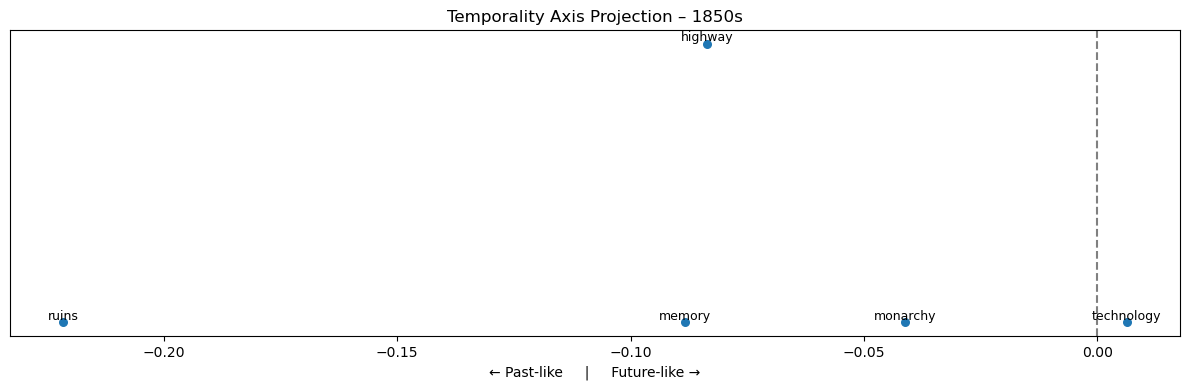

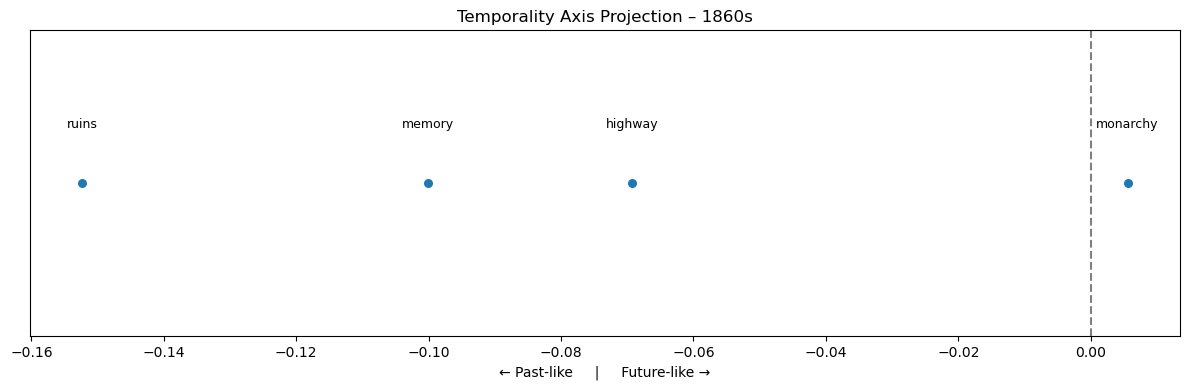

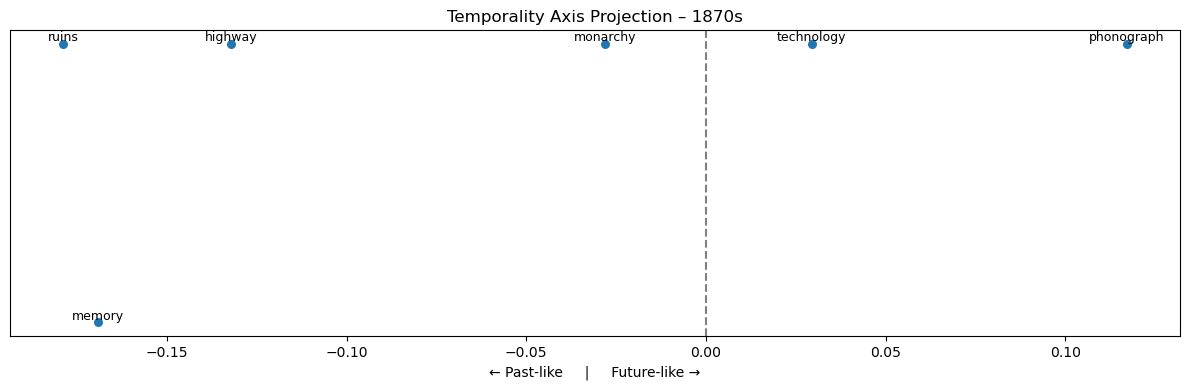

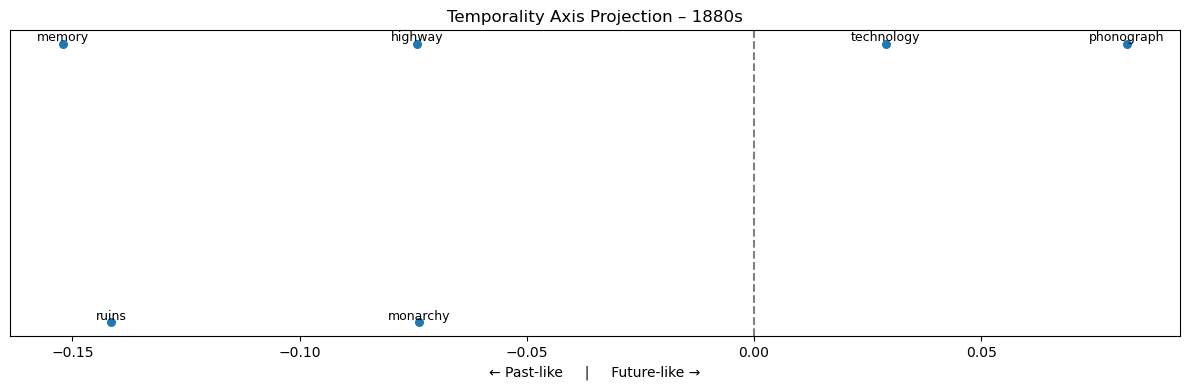

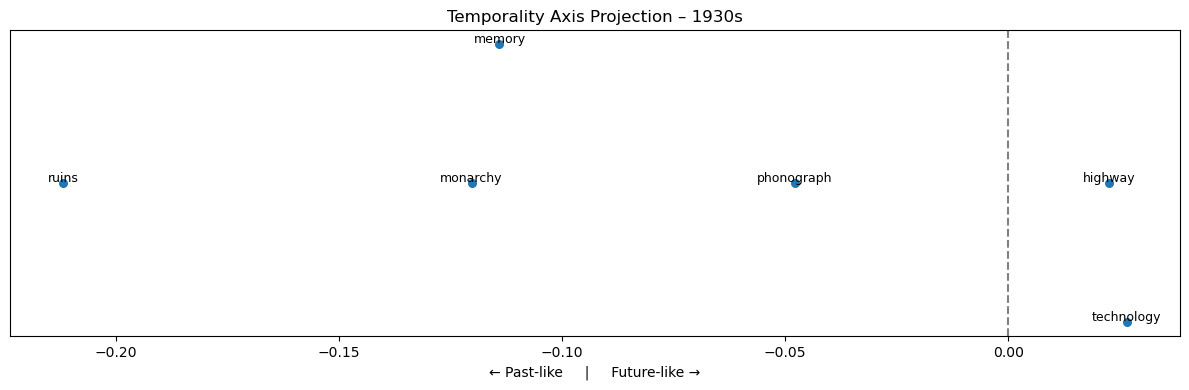

In [90]:
for decade, model in models.items():
    axis = compute_temporality_axis(model, pairs)
    plot_temporality_words(model, axis, words_to_plot, decade_label=decade)

In [84]:
def top_future_past_words(model, axis, top_n=10):
    """
    Given:
        model = a gensim Word2Vec model
        axis  = temporality axis vector (or None)
    Returns:
        (top_future, top_past) 
        where each is a list of (word, score)
    """
    if axis is None:
        return [], []   # cannot compute scores

    # Pre-normalize axis
    axis_norm = axis / np.linalg.norm(axis)

    words = model.wv.index_to_key
    scores = []

    for w in words:
        vec = model.wv[w]
        vec_norm = vec / np.linalg.norm(vec)
        score = float(np.dot(vec_norm, axis_norm))
        scores.append((w, score))

    # Sort once
    scores_sorted = sorted(scores, key=lambda x: x[1], reverse=True)

    top_future = scores_sorted[:top_n]            # highest → future-like
    top_past   = scores_sorted[-top_n:][::-1]     # lowest → past-like

    return top_future, top_past


In [85]:
top_results = {}  # decade → {"future": [...], "past": [...]}

for decade, model in models.items():
    print(f"\nProcessing {decade}...")

    axis = compute_temporality_axis(model, pairs)

    future_like, past_like = top_future_past_words(model, axis, top_n=10)

    top_results[decade] = {
        "future": future_like,
        "past": past_like
    }

    print(f"Top 10 future-like words for {decade}:")
    for w, s in future_like:
        print(f"  {w:20s} {s:.4f}")

    print(f"\nTop 10 past-like words for {decade}:")
    for w, s in past_like:
        print(f"  {w:20s} {s:.4f}")



Processing 1850s...
Top 10 future-like words for 1850s:
  modern               0.3223
  tomorrow             0.3170
  moden                0.3121
  neow                 0.3115
  rcoms                0.3013
  poesession           0.2983
  apliy                0.2973
  new                  0.2967
  newv                 0.2964
  irooms               0.2907

Top 10 past-like words for 1850s:
  antiquity            -0.3406
  old                  -0.3362
  longshoreman         -0.3283
  past                 -0.3227
  ago                  -0.3143
  yesterday            -0.3141
  terday               -0.3093
  irishwoman           -0.3045
  kille                -0.2943
  stalwart             -0.2863

Processing 1860s...
Top 10 future-like words for 1860s:
  modern               0.3988
  improvements         0.3711
  provements           0.3429
  modem                0.3041
  dern                 0.3033
  tomorrow             0.2936
  conveniences         0.2882
  new                  0.2875
 

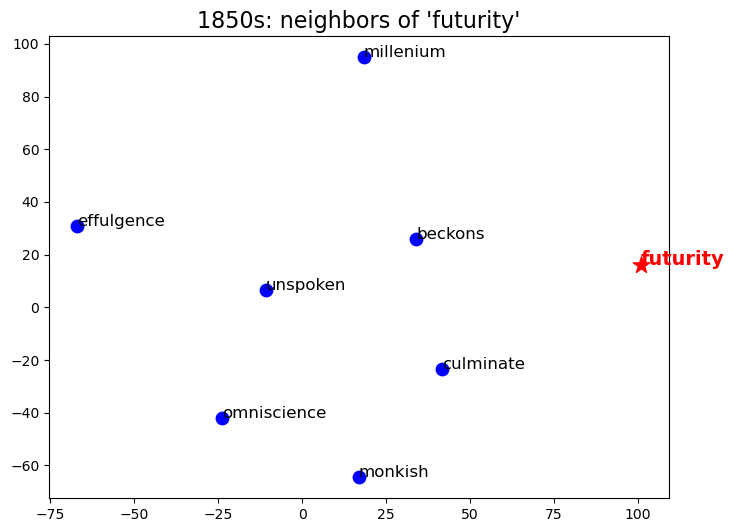

Word 'futurity' missing from vocabulary for 1860s.
Word 'futurity' missing from vocabulary for 1870s.


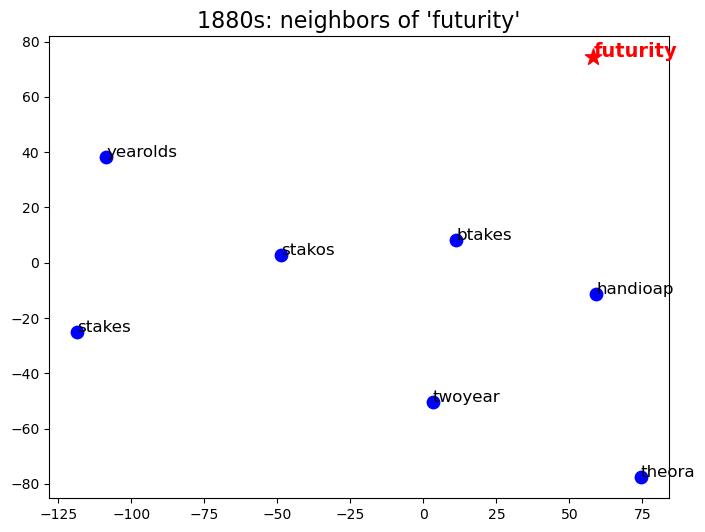

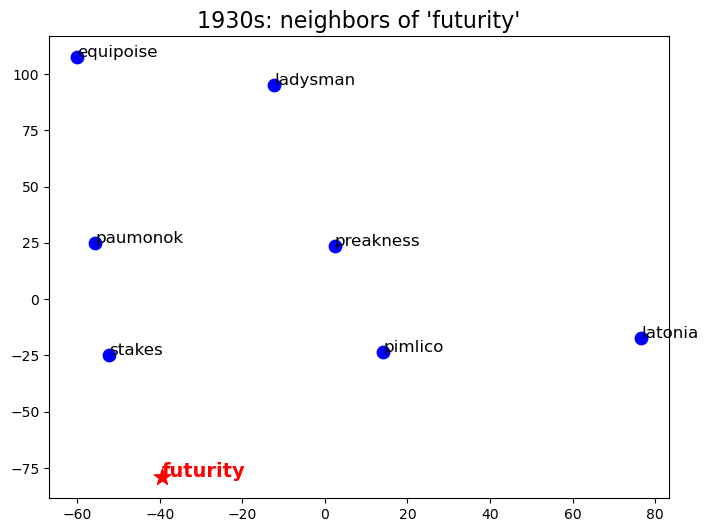

In [86]:
for decade, model in models.items():
    plot_word_neighbors("futurity", model, decade, topn=7)

In [87]:
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

def save_word_neighbors_plot(word, model, decade, save_dir, topn=15, show=True):
    """
    Generates and saves a TSNE plot of a word and its neighbors.
    
    Parameters:
        word (str): The target word.
        model (Word2Vec): The gensim model.
        decade (str): Decade label for the plot title + filename.
        save_dir (str): Directory where the figure will be saved.
        topn (int): Number of neighbors to include.
        show (bool): Whether to display the figure.
    """

    # Ensure output directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Get neighbors
    try:
        neighbors = model.wv.most_similar(word, topn=topn)
    except KeyError:
        print(f"⚠️ Word '{word}' not found for {decade}. Skipping.")
        return

    words_to_plot = [word] + [n for n, _ in neighbors]
    vectors = np.array([model.wv[w] for w in words_to_plot])

    # TSNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    coords = tsne.fit_transform(vectors)

    # Plotting
    plt.figure(figsize=(8, 6))
    for (x, y), w in zip(coords, words_to_plot):
        if w == word:
            plt.scatter(x, y, s=150, color="red", marker="*")
            plt.text(x+0.01, y+0.01, w, fontsize=14, fontweight="bold", color="red")
        else:
            plt.scatter(x, y, s=80, color="blue")
            plt.text(x+0.01, y+0.01, w, fontsize=12)

    plt.title(f"{decade}: neighbors of '{word}'", fontsize=16)

    # Save file
    filename = f"{word}_neighbors_{decade}.png"
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close()

    print(f"Saved plot for {decade} → {save_path}")

"""

IndentationError: unexpected indent (3340612489.py, line 10)